In [1]:
import torch
import torchvision
from torchvision import utils
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import sys
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sn
import torch.optim as optim

DEVICE_DEFAULT=torch.device("cuda" if torch.cuda.is_available() else "cpu")
DRIVE="/content/drive/temp/"

# Utility Functions

In [3]:
def pbar(p=0, msg="", bar_len=20):
    sys.stdout.write("\033[K")
    sys.stdout.write("\x1b[2K" + "\r")
    block = int(round(bar_len * p))
    text = "Progress: [{}] {}% {}".format(
        "\x1b[32m" + "=" * (block - 1) + ">" + "\033[0m" + "-" * (bar_len - block),
        round(p * 100, 2),
        msg,
    )
    print(text, end="\r")
    if p == 1:
        print()

class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.metrics = {}

    def add(self, batch_metrics):
        for key, value in batch_metrics.items():
            if key in self.metrics.items():
                self.metrics[key].append(value)
            else:
                self.metrics[key] = [value]

    def get(self):
        return {key: np.mean(value) for key, value in self.metrics.items()}

    def msg(self):
        avg_metrics = {key: np.mean(value) for key, value in self.metrics.items()}
        return "".join(["[{}] {:.5f} ".format(key, value) for key, value in avg_metrics.items()])

def add_noise(inputs, noise_factor):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

def train(model, optim, lr_sched=None, epochs=200, device=DEVICE_DEFAULT, criterion=None, metric_meter=None, out_dir="out/", sparseAE=False, noiseFactor=None):
    if sparseAE:
        print("Using L1 Penalty Term in Training.")
    if noiseFactor != None:
        print("Adding Noise to the training data.")

    model.to(device)
    train_loss_for_plot = []
    val_loss_for_plot = []
    
    for epoch in range(epochs):
        model.train()
        metric_meter.reset()
        for indx, (inp, _) in enumerate(train_loader):
            inp = inp.to(device)

            optim.zero_grad()
            
            if sparseAE:
                out, hid = model.forward(inp, ret_hidden=True)
                loss_MSE = criterion(out, inp)
                loss_L1 = hid.abs().sum()
                loss = loss_MSE + DEG_OF_SPARSITY * loss_L1
                metric_meter.add({"loss MSE": loss_MSE.item(), "loss L1": loss_L1.item()})
            elif noiseFactor != None:
                noisy_inp = add_noise(inp, noiseFactor)
                out = model.forward(noisy_inp)
                loss = criterion(out, inp)
            else:
                out = model.forward(inp)
                loss = criterion(out, inp)

            metric_meter.add({"train loss": loss.item()})
            loss.backward()
            optim.step()

            pbar(indx / len(train_loader), msg=metric_meter.msg())
        pbar(1, msg=metric_meter.msg())
        train_loss_for_plot.append(metric_meter.get()["train loss"])
    
        model.eval()
        metric_meter.reset()
        for indx, (inp, _) in enumerate(val_loader):
            inp = inp.to(device)

            out = model.forward(inp)
            loss = criterion(out, inp)

            metric_meter.add({"val loss": loss.item()})
            pbar(indx / len(val_loader), msg=metric_meter.msg())
        pbar(1, msg=metric_meter.msg())

        val_metrics = metric_meter.get()
        val_loss_for_plot.append(val_metrics["val loss"])
        lr_sched.step()
        
    return train_loss_for_plot, val_loss_for_plot

# Data Loading

In [ ]:
data_train = datasets.MNIST('~/mnist_data', train=True, download=True, transform=T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]))
data_test = datasets.MNIST('~/mnist_data', train=False, download=True, transform=T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]))

In [5]:
# Split train data into train(50000) and validation(10000)

train_indices, val_indices, _, _ = train_test_split(
    range(len(data_train)),
    data_train.targets,
    stratify=data_train.targets, # Make sure that the percentage of each class is same in both train & val
    test_size=10000,
)

train_split = Subset(data_train, train_indices)
val_split = Subset(data_train, val_indices)

In [6]:
print(f'Number of training examples: {len(train_split)}')
print(f'Number of validation examples: {len(val_split)}')
print(f'Number of testing examples: {len(data_test)}')

Number of training examples: 50000
Number of validation examples: 10000
Number of testing examples: 10000


In [7]:
BATCH_SIZE = 64
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE)

# Part 1 : Comparing PCA and Autoencoders

# PCA

In [7]:
X_train = np.array([np.array(x[0]).flatten() for x in train_split])
X_val = np.array([np.array(x[0]).flatten() for x in val_split])
X_test = np.array([np.array(x[0]).flatten() for x in data_test])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

cov_mat = np.cov(X_train.T)

(50000, 784)
(10000, 784)
(10000, 784)


In [8]:
eig_val, eig_vec = np.linalg.eig(cov_mat)
idx = eig_val.argsort()[::-1]
eig_val, eig_vec = eig_val[idx].real, eig_vec[:, idx].real

In [9]:
def myMSE(pred, act):
    return np.mean(np.square(pred-act))

In [10]:
print(myMSE(X_train, (X_train @ eig_vec[:,:30]) @ np.linalg.pinv(eig_vec[:,:30])))
print(myMSE(X_val, (X_val @ eig_vec[:,:30]) @ np.linalg.pinv(eig_vec[:,:30])))
print(myMSE(X_test, (X_test @ eig_vec[:,:30]) @ np.linalg.pinv(eig_vec[:,:30])))

0.01846386541217547
0.018401478797684896
0.01801688559100428


# AE

In [ ]:
class AE(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.enc_fc1 = nn.Linear(784, 512)
        self.enc_fc2 = nn.Linear(512, 256)
        self.enc_fc3 = nn.Linear(256, 128)
        self.enc_fc4 = nn.Linear(128, 30)
        
        self.dec_fc1 = nn.Linear(30, 128)
        self.dec_fc2 = nn.Linear(128, 256)
        self.dec_fc3 = nn.Linear(256, 784)
        
        self.act = nn.ReLU()
        
    def forward(self, batch):
        
        out = self.act(self.enc_fc1(batch))
        out = self.act(self.enc_fc2(out))
        out = self.act(self.enc_fc3(out))
        out = self.act(self.enc_fc4(out))
        
        out = self.act(self.dec_fc1(out))
        out = self.act(self.dec_fc2(out))
        out = self.act(self.dec_fc3(out))
        
        return out

In [ ]:
model = AE()

EPOCHS = 25

optim = torch.optim.SGD(model.parameters(), lr=10**-1, momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()

train_loss_for_plot, val_loss_for_plot = \
    train(model, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

In [ ]:
plt.plot(train_loss_for_plot, label="Train Loss")
plt.plot(val_loss_for_plot, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.show()

In [ ]:
for cls in range(10):
    ctr = 0
    for idx, (_, lbl) in enumerate(data_test):
        if lbl == cls:
            ctr += 1
            if ctr == 3:
                plt.subplot(5, 6, cls*3+1)
                plt.imshow(data_test[idx][0].reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("True")

                plt.subplot(5, 6, cls*3+2)
                plt.imshow(((data_test[idx][0] @ eig_vec[:,:30]) @ np.linalg.pinv(eig_vec[:,:30])).reshape((28,28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("PCA")

                plt.subplot(5, 6, cls*3+3)
                plt.imshow(model.forward(data_test[idx][0].to(DEVICE_DEFAULT)).to(torch.device('cpu')).detach().numpy().reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("AE")
                break

plt.show()

# Part 2 : Varying Hidden Unit Size

In [83]:
class AE2(nn.Module):
    def __init__(self, hidden_dim):
        
        super().__init__()
        
        self.enc = nn.Linear(784, hidden_dim)
        
        self.dec = nn.Linear(hidden_dim, 784)
        
        self.act = nn.ReLU()
        
    def forward(self, batch):
        
        out = self.act(self.enc(batch))
        
        out = self.act(self.dec(out))
        
        return out

In [ ]:
EPOCHS = 10

model64 = AE2(64)
optim = torch.optim.SGD(model64.parameters(), lr=0.1, momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
tLoss64, vLoss64 = train(model64, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

model128 = AE2(128)
optim = torch.optim.SGD(model128.parameters(), lr=0.1, momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
tLoss128, vLoss128 = train(model128, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

model256 = AE2(256)
optim = torch.optim.SGD(model256.parameters(), lr=0.1, momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
tLoss256, vLoss256 = train(model256, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

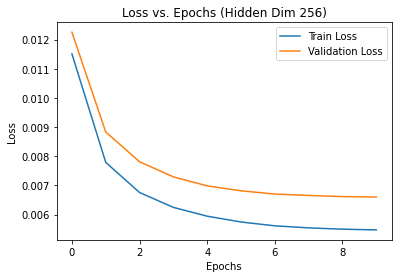

In [85]:
plt.plot(tLoss256, label="Train Loss")
plt.plot(vLoss256, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs (Hidden Dim 256)")
plt.show()

In [ ]:
fashion_train = datasets.FashionMNIST('~/mnist_fashion', train=True, download=True, transform=T.Compose([T.ToTensor(), T.Lambda(torch.flatten)]))

# example_img = fashion_train[100][0] # MNIST Fashion
# example_img = data_test[10][0] # MNIST Digit Test
example_img = torch.rand((784,))

plt.subplot(1, 4, 1)
plt.imshow(example_img.reshape((28,28)), cmap='gray')
plt.axis('off'); plt.ioff()
plt.title('True')

plt.subplot(1, 4, 2)
plt.imshow(model64.forward(example_img.to(DEVICE_DEFAULT)).to(torch.device('cpu')).detach().numpy().reshape((28, 28)), cmap='gray')
plt.axis('off'); plt.ioff()
plt.title('64')

plt.subplot(1, 4, 3)
plt.imshow(model128.forward(example_img.to(DEVICE_DEFAULT)).to(torch.device('cpu')).detach().numpy().reshape((28, 28)), cmap='gray')
plt.axis('off'); plt.ioff()
plt.title('128')

plt.subplot(1, 4, 4)
plt.imshow(model256.forward(example_img.to(DEVICE_DEFAULT)).to(torch.device('cpu')).detach().numpy().reshape((28, 28)), cmap='gray')
plt.axis('off'); plt.ioff()
plt.title('256')

plt.show()

# Part 3 : Sparse Autoencoders

In [11]:
class SparseAE(nn.Module):
    def __init__(self, hidden_dim):
        
        super().__init__()
        
        self.enc = nn.Linear(784, hidden_dim)
        
        self.dec = nn.Linear(hidden_dim, 784)
        
        self.act = nn.ReLU()
        
    def forward(self, batch, ret_hidden=False):
        
        hid = self.act(self.enc(batch))
        
        out = self.act(self.dec(hid))

        if ret_hidden:
            return out, hid
        else:
            return out

In [ ]:
EPOCHS = 10

out_dir = "Part1"
os.makedirs(out_dir, exist_ok=True)

model_sparse2 = SparseAE(1024) # Overcomplete AE so taking dim > 784
optim = torch.optim.SGD(model_sparse2.parameters(), lr=10**-(1.5), momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
DEG_OF_SPARSITY = 0.00001 # Medium restriction on sparsity
train_loss_sparse2, val_loss_sparse2 = train(model_sparse2, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir, sparseAE=True)

model_sparse1 = SparseAE(1024) # Overcomplete AE so taking dim > 784
optim = torch.optim.SGD(model_sparse1.parameters(), lr=10**-(1.5), momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
DEG_OF_SPARSITY = 0.001 # Heavy restriction on sparsity i.e., activation of hidden layer zero, so same output for all images.
train_loss_sparse1, val_loss_sparse1 = train(model_sparse1, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir, sparseAE=True)

model_sparse3 = SparseAE(1024) # Overcomplete AE so taking dim > 784
optim = torch.optim.SGD(model_sparse3.parameters(), lr=10**-(1.5), momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
DEG_OF_SPARSITY = 0 # No restriction on sparsity, leads to overfitting.
train_loss_sparse3, val_loss_sparse3 = train(model_sparse3, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir, sparseAE=True)

In [ ]:
plt.plot(train_loss_sparse1, label="Train Loss")
plt.plot(val_loss_sparse1, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs (Sparsity = 1e-3)")
plt.ylim([0.04, 0.09])
plt.show()

plt.plot(train_loss_sparse2, label="Train Loss")
plt.plot(val_loss_sparse2, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs (Sparsity = 1e-5)")
plt.show()

plt.plot(train_loss_sparse3, label="Train Loss")
plt.plot(val_loss_sparse3, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs (Sparsity = 0)")
plt.show()

In [ ]:
plt.figure(figsize=(16, 10))
for cls in range(10):
    ctr = 0
    for idx, (_, lbl) in enumerate(data_test):
        if lbl == cls:
            ctr += 1
            if ctr == 3:
                plt.subplot(5, 8, cls*4+1)
                plt.imshow(data_test[idx][0].reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("True")

                plt.subplot(5, 8, cls*4+2)
                plt.imshow(model_sparse1.forward(data_test[idx][0].to(DEVICE_DEFAULT)).to(torch.device('cpu')).detach().numpy().reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("Sparsity = 1e-3")

                plt.subplot(5, 8, cls*4+3)
                plt.imshow(model_sparse2.forward(data_test[idx][0].to(DEVICE_DEFAULT)).to(torch.device('cpu')).detach().numpy().reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("Sparsity = 1e-5")

                plt.subplot(5, 8, cls*4+4)
                plt.imshow(model_sparse3.forward(data_test[idx][0].to(DEVICE_DEFAULT)).to(torch.device('cpu')).detach().numpy().reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("Sparsity = 0")
                break

plt.show()

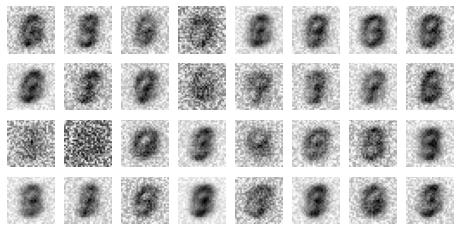

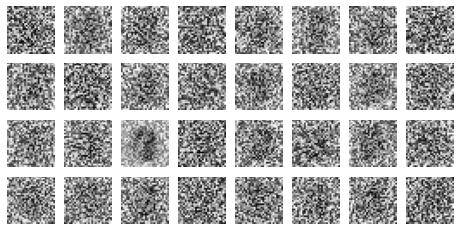

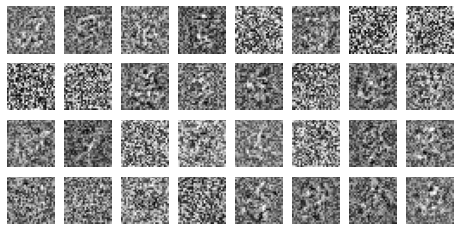

In [82]:
wt_idx = [random.randint(0, 1023) for _ in range(32)]

plt.figure(figsize=(8,4))
for idx, x in enumerate(wt_idx):
    plt.subplot(4, 8, idx+1)
    plt.imshow(model_sparse1.enc.weight[x,:].to(torch.device("cpu")).detach().numpy().reshape((28, 28)), cmap='gray')
    plt.axis('off'); plt.ioff()
plt.show()

plt.figure(figsize=(8,4))
for idx, x in enumerate(wt_idx):
    plt.subplot(4, 8, idx+1)
    plt.imshow(model_sparse2.enc.weight[x,:].to(torch.device("cpu")).detach().numpy().reshape((28, 28)), cmap='gray')
    plt.axis('off'); plt.ioff()
plt.show()

plt.figure(figsize=(8,4))
for idx, x in enumerate(wt_idx):
    plt.subplot(4, 8, idx+1)
    plt.imshow(model_sparse3.enc.weight[x,:].to(torch.device("cpu")).detach().numpy().reshape((28, 28)), cmap='gray')
    plt.axis('off'); plt.ioff()
plt.show()

# Part 4 Denoising AE

In [ ]:
NOISE_FACTOR = 0.3
EPOCHS = 20
model = AE2(256)

optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
tLoss, vLoss = train(model, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir, noiseFactor=NOISE_FACTOR)

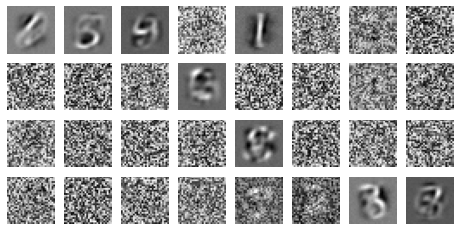

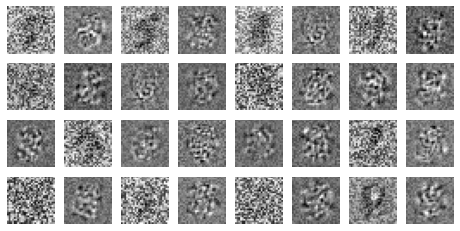

In [102]:
wt_idx = [random.randint(0, 255) for _ in range(32)]

plt.figure(figsize=(8,4))
for idx, x in enumerate(wt_idx):
    plt.subplot(4, 8, idx+1)
    plt.imshow(model.enc.weight[x,:].to(torch.device("cpu")).detach().numpy().reshape((28, 28)), cmap='gray')
    plt.axis('off'); plt.ioff()
plt.show()

plt.figure(figsize=(8,4))
for idx, x in enumerate(wt_idx):
    plt.subplot(4, 8, idx+1)
    plt.imshow(model256.enc.weight[x,:].to(torch.device("cpu")).detach().numpy().reshape((28, 28)), cmap='gray')
    plt.axis('off'); plt.ioff()
plt.show()

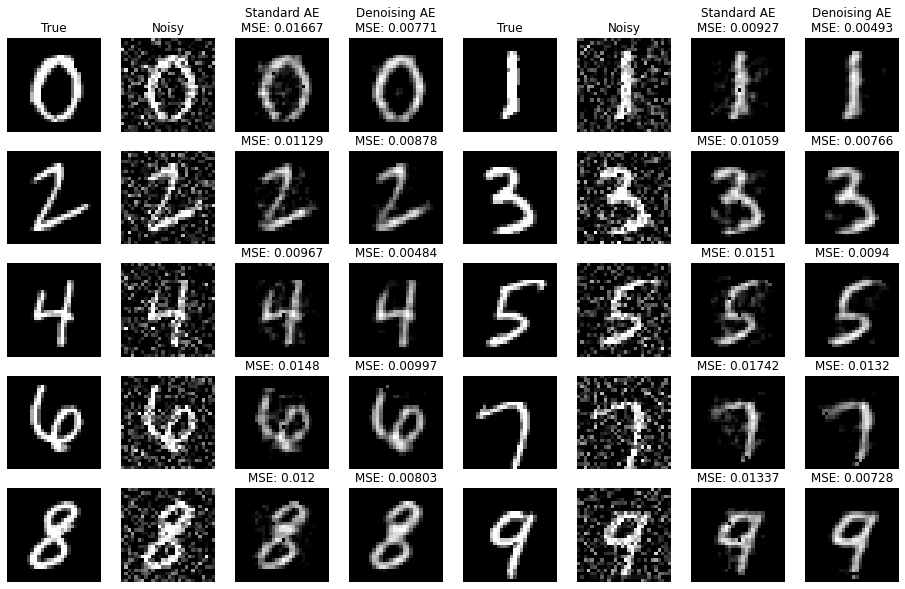

In [116]:
plt.figure(figsize=(16, 10))
for cls in range(10):
    ctr = 0
    for idx, (_, lbl) in enumerate(data_test):
        if lbl == cls:
            ctr += 1
            if ctr == 3:

                img_cpu = data_test[idx][0]
                img_cpu_noisy = add_noise(img_cpu, NOISE_FACTOR)
                img_gpu_noisy = img_cpu_noisy.to(DEVICE_DEFAULT)

                plt.subplot(5, 8, cls*4+1)
                plt.imshow(img_cpu.reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("True")

                plt.subplot(5, 8, cls*4+2)
                plt.imshow(img_cpu_noisy.reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                if cls == 0 or cls == 1: plt.title("Noisy")

                plt.subplot(5, 8, cls*4+3)
                model_out = model256.forward(img_gpu_noisy).to(torch.device('cpu')).detach().numpy()
                plt.imshow(model_out.reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                mse = str(round(myMSE(img_cpu.detach().numpy(), model_out), 5))
                if cls == 0 or cls == 1: plt.title("Standard AE\nMSE: " + mse)
                else: plt.title("MSE: " + mse)


                plt.subplot(5, 8, cls*4+4)
                model_out = model.forward(img_gpu_noisy).to(torch.device('cpu')).detach().numpy()
                plt.imshow(model_out.reshape((28, 28)), cmap='gray')
                plt.axis('off'); plt.ioff()
                mse = str(round(myMSE(img_cpu.detach().numpy(), model_out), 5))
                if cls == 0 or cls == 1: plt.title("Denoising AE\nMSE: " + mse)
                else: plt.title("MSE: " + mse)
                break

plt.show()

# Part 5 Convolutional AE

In [49]:
# i) Unpooling
class ConvAE1(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.enc_conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.enc_pool = nn.MaxPool2d(2, return_indices=True)

        # Used to reduce the number of channels
        self.dec_conv3 = nn.Conv2d(16, 16, 1)
        self.dec_conv2 = nn.Conv2d(16, 8, 1)
        self.dec_conv1 = nn.Conv2d(8, 1, 1)

        self.dec_unpool = nn.MaxUnpool2d(2)
        
    def forward(self, batch, ret_hidden=False):
        
        batch = torch.reshape(batch, (-1, 1, 28, 28))
        
        out = batch

        out = self.enc_conv1(batch)
        osz1 = out.shape
        out, ind1 = self.enc_pool(out)

        out = self.enc_conv2(out)        
        osz2 = out.shape
        out, ind2 = self.enc_pool(out)

        out = self.enc_conv3(out)        
        osz3 = out.shape
        out, ind3 = self.enc_pool(out)
        
        out = self.dec_unpool(out, ind3, output_size=osz3)
        out = self.dec_conv3(out)
        
        out = self.dec_unpool(out, ind2, output_size=osz2)
        out = self.dec_conv2(out)
        
        out = self.dec_unpool(out, ind1, output_size=osz1)
        out = self.dec_conv1(out)

        return torch.reshape(out, (-1, 28*28))

# ii) Unpooling + Deconvolution
class ConvAE2(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.enc_conv1 = nn.Conv2d(1, 8, 3)
        self.enc_conv2 = nn.Conv2d(8, 16, 3)
        self.enc_conv3 = nn.Conv2d(16, 16, 3)
        self.enc_pool = nn.MaxPool2d(2, return_indices=True)
        
        self.dec_deconv1 = nn.ConvTranspose2d(16, 16, 3)
        self.dec_deconv2 = nn.ConvTranspose2d(16, 8, 3)
        self.dec_deconv3 = nn.ConvTranspose2d(8, 1, 3)
        self.dec_unpool = nn.MaxUnpool2d(2)
        
    def forward(self, batch, ret_hidden=False):
        
        batch = torch.reshape(batch, (-1, 1, 28, 28))
        
        out = self.enc_conv1(batch)
        osz1 = out.shape
        out, ind1 = self.enc_pool(out)
        
        out = self.enc_conv2(out)
        osz2 = out.shape
        out, ind2 = self.enc_pool(out)
        
        out = self.enc_conv3(out)
        osz3 = out.shape
        out, ind3 = self.enc_pool(out)
        
        out = self.dec_unpool(out, ind3, output_size=osz3)
        out = self.dec_deconv1(out)
        
        out = self.dec_unpool(out, ind2, output_size=osz2)
        out = self.dec_deconv2(out)
        
        out = self.dec_unpool(out, ind1, output_size=osz1)
        out = self.dec_deconv3(out)

        return torch.reshape(out, (-1, 28*28))

# iii) Deconvolution
class ConvAE3(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.enc_conv1 = nn.Conv2d(1, 8, 3)
        self.enc_conv2 = nn.Conv2d(8, 16, 3)
        self.enc_conv3 = nn.Conv2d(16, 16, 3)
        self.enc_pool = nn.MaxPool2d(2, return_indices=True)
        
        self.dec_deconv1 = nn.ConvTranspose2d(16, 16, 5, stride=2)
        self.dec_deconv2 = nn.ConvTranspose2d(16, 8, 5, stride=2)
        self.dec_deconv3 = nn.ConvTranspose2d(8, 1, 4, stride=2)
        # self.dec_unpool = nn.MaxUnpool2d(2)
        
    def forward(self, batch, ret_hidden=False):
        
        batch = torch.reshape(batch, (-1, 1, 28, 28))
        
        out = self.enc_conv1(batch)
        osz1 = out.shape
        out, ind1 = self.enc_pool(out)
        
        out = self.enc_conv2(out)
        osz2 = out.shape
        out, ind2 = self.enc_pool(out)
        
        out = self.enc_conv3(out)
        osz3 = out.shape
        out, ind3 = self.enc_pool(out)
        
        out = self.dec_deconv1(out)

        out = self.dec_deconv2(out)

        out = self.dec_deconv3(out)

        return torch.reshape(out, (-1, 28*28))

In [ ]:
out_dir = "Part1"
os.makedirs(out_dir, exist_ok=True)

EPOCHS = 10

model1 = ConvAE1()
optim = torch.optim.SGD(model1.parameters(), lr=10**-(1.5), momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
train_loss1, val_loss1 = train(model1, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

model2 = ConvAE2()
optim = torch.optim.SGD(model2.parameters(), lr=10**-(1.5), momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
train_loss2, val_loss2 = train(model2, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

model3 = ConvAE3()
optim = torch.optim.SGD(model3.parameters(), lr=10**-(1.5), momentum=0.99)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)
criterion = nn.MSELoss()
metric_meter = AvgMeter()
train_loss3, val_loss3 = train(model3, optim, lr_sched, epochs=EPOCHS, criterion=criterion, metric_meter=metric_meter, out_dir=out_dir)

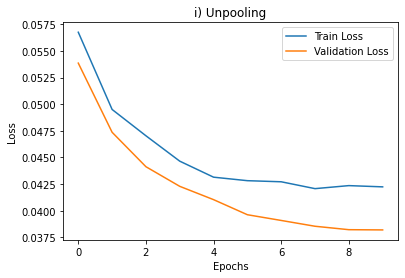

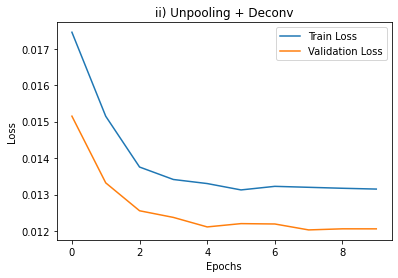

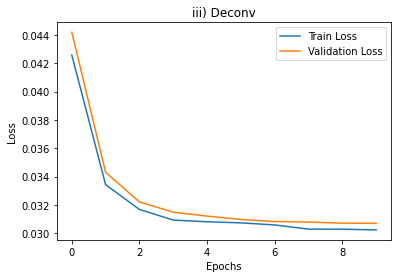

In [56]:
plt.plot(train_loss1, label="Train Loss")
plt.plot(val_loss1, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("i) Unpooling")
plt.show()

plt.plot(train_loss2, label="Train Loss")
plt.plot(val_loss2, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ii) Unpooling + Deconv")
plt.show()

plt.plot(train_loss3, label="Train Loss")
plt.plot(val_loss3, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("iii) Deconv")
plt.show()

In [ ]:
wt_idx = [random.randint(0, 255) for _ in range(32)]

plt.figure(figsize=(8,4))
for idx, x in enumerate(wt_idx):
    plt.subplot(4, 8, idx+1)
    plt.imshow(model.enc.dec_deconv3[x,:].to(torch.device("cpu")).detach().numpy().reshape((28, 28)), cmap='gray')
    plt.axis('off'); plt.ioff()
plt.show()

In [51]:
model_dim = ConvAE1()
example = 100
out_img = model_dim.forward(train_split[example][0])

Model ii)
ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))


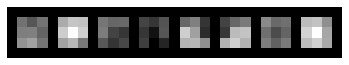


Model iii)
ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2))


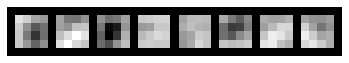




Model ii)
ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1))


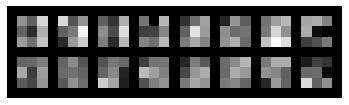


Model iii)
ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2))


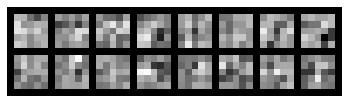




Model ii)
ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))


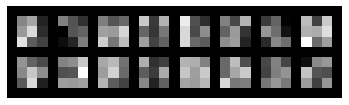


Model iii)
ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(2, 2))


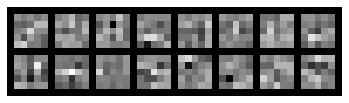

In [77]:
# Reference: https://stackoverflow.com/a/55604568
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=1)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

for L in range(1,4):

    print("Model ii)")
    model_children = list(model2.children())
    layer = model_children[-1 * L - 1]; print(layer)
    filter = layer.weight.data.clone().to(torch.device("cpu"))
    visTensor(filter); plt.axis('off'); plt.ioff()
    plt.show()

    print("\nModel iii)")
    model_children = list(model3.children())
    layer = model_children[-1 * L]; print(layer)
    filter = layer.weight.data.clone().to(torch.device("cpu"))
    visTensor(filter); plt.axis('off'); plt.ioff()
    plt.show()

    print("\n"*2)